<a href="https://colab.research.google.com/github/rubanzasilva/textual_inversion/blob/main/diffusers/stable_conceptualizer_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Conceptualizer - Stable Diffusion using learned concepts

The Stable Conceptualizer enables you to use pre-learned concepts on Stable Diffusion via textual-inversion using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).

![Textual Inversion example](https://textual-inversion.github.io/static/images/editing/colorful_teapot.JPG)

Navigate the [library of pre-learned concepts](https://huggingface.co/sd-concepts-library) here. For teaching the model new concepts using Textual Inversion, [use this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb).


## Initial setup

In [1]:
#@title Install the required libs
!pip install -qq diffusers==0.16.1 transformers ftfy accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.8 MB/s eta 0:00:00


In [2]:
%pip install --upgrade diffusers transformers

  Using cached diffusers-0.34.0-py3-none-any.whl.metadata (20 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.6 MB/s eta 0:00:00
Using cached diffusers-0.34.0-py3-none-any.whl (3.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.14.1
    Uninstalling tokenizers-0.14.1:
      Successfully uninstalled tokenizers-0.14.1
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.21.4
    Uninstalling diffusers-0.21.4:
      Successfully uninstalled diffusers-0.21.4
  Attempting uninstall: transfor

In [1]:
#@title Login to the Hugging Face Hub
from huggingface_hub import notebook_login

notebook_login()

In [2]:
#@title Import required libraries
import os
import torch

import PIL
from PIL import Image

from diffusers import StableDiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Run Stable Diffusion with pre-trained Learned Concepts
If you want to teach Stable Diffusion your own concepts, [use this notebook](#).



In [3]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use. This should match the one used for training the embeddings.
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2" #@param {type:"string"}

In [4]:
#@title Load your concept here
#@markdown Enter the `repo_id` for a concept you like (you can find pre-learned concepts in the public [SD Concepts Library](https://huggingface.co/sd-concepts-library))
repo_id_embeds = "silvaKenpachi/onepiecestyle" #@param {type:"string"}

In [5]:
#@title Load the Stable Diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    torch_dtype=torch.float16
).to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
#@title Load the concept into pipeline
pipe.load_textual_inversion(repo_id_embeds)

learned_embeds.bin:   0%|          | 0.00/5.79k [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

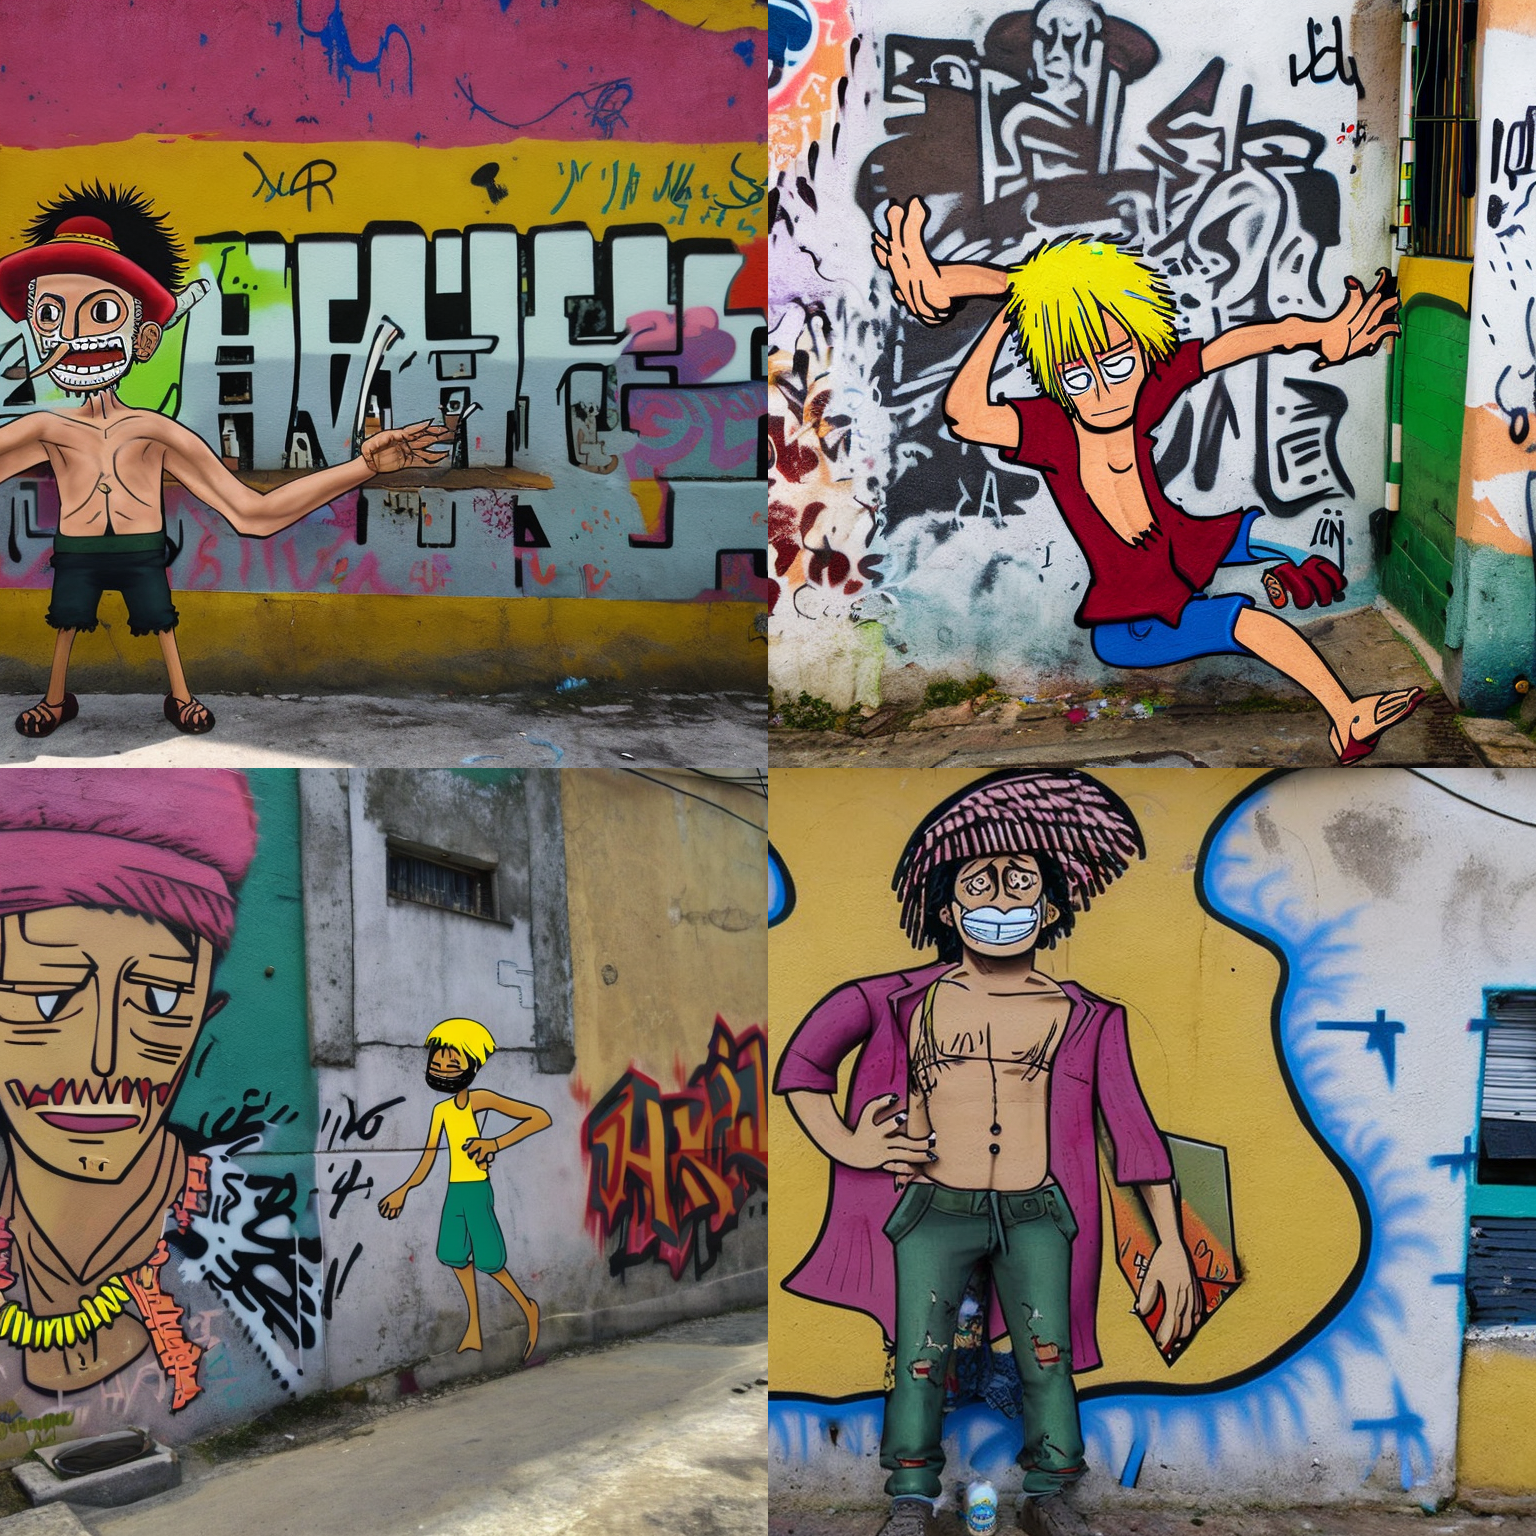

In [7]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "a grafitti in a favela wall with a man in the <one-piece-styling> on it" #@param {type:"string"}

num_samples = 2 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}

all_images = []
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid